In [10]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT= "https://github.com/ageron/handson-ml/tree/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        print("Downloading...")
    tgz_path = os.path.join(housing_path, "housing.tgz")
    print("Target Path: " + tgz_path)
    target = urllib.request.urlretrieve(housing_url, tgz_path)
    print("Extracting..."+ target[0])
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    print("Download complete")



In [11]:
import pandas as pd
import numpy as np
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#fetch_housing_data(HOUSING_URL, HOUSING_PATH)
housing = load_housing_data(HOUSING_PATH)
print(housing.head())

print(housing['ocean_proximity'].value_counts())



   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290

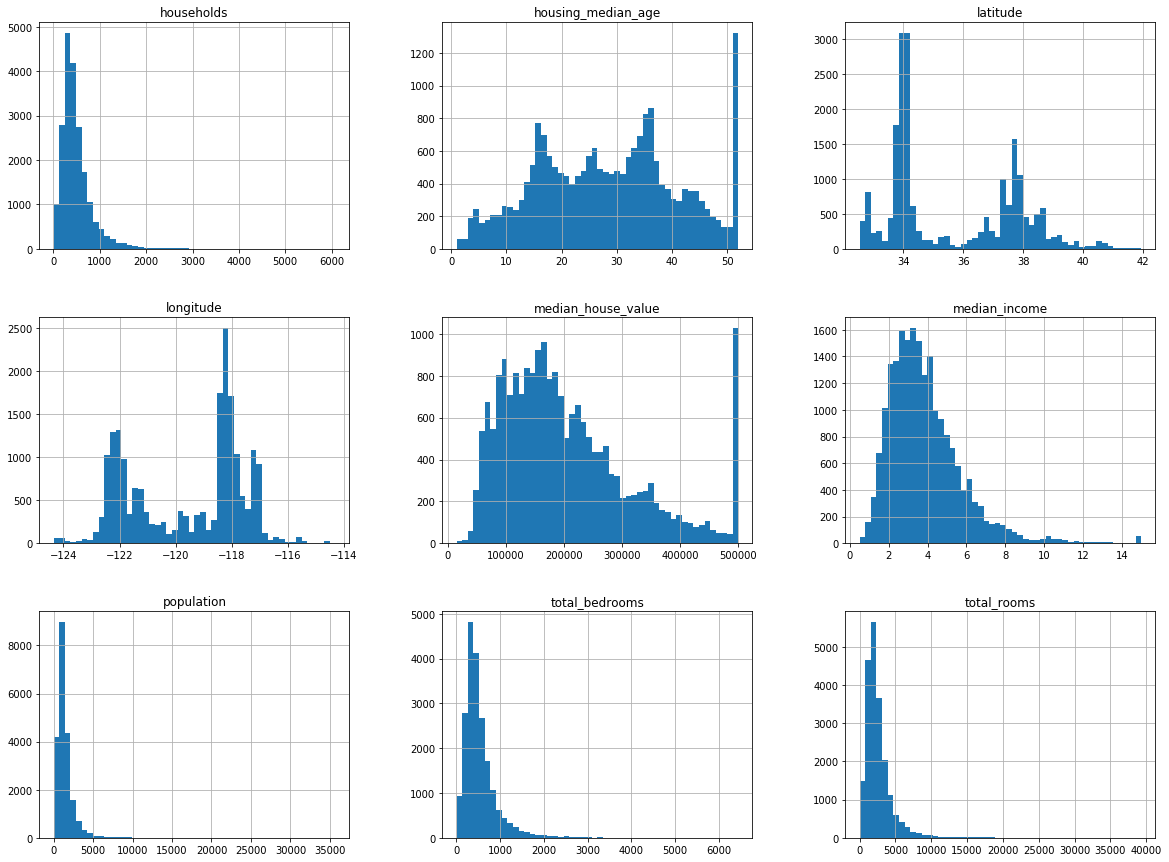

In [12]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [13]:
housing.info()

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

For testing purposes, we'll want a *stratified split* to ensure representative consistency. 
For example, if you were to conduct a survey of 1000 americans,k you wouldn't want to do it purely randomly.
51.3% of americans are female for instance, while 48.7 americans are male, so you'd ideally want to have a "strata" of
513 females and 487 males in your survey.

1. Let's bracket the median income levels into income categories.

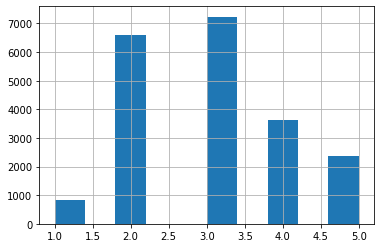

In [14]:
housing["income_cat"]= pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6.,np.inf], labels=[1,2,3,4,5])
housing["income_cat"].hist()

Use sklearn to perform the stratified train/test split

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]

In [16]:
strat_test_set["income_cat"].value_counts()/ len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
strat_train_set["income_cat"].value_counts()/ len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [18]:
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Now revert the original dataset to normal, without the new bracketed category

In [19]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let's plot the geographical information of our data set. It should roughly look like California base on our source. 

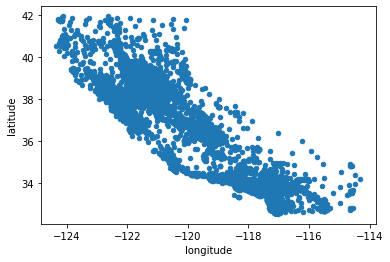

In [22]:
housing.plot(kind='scatter', x='longitude', y="latitude")

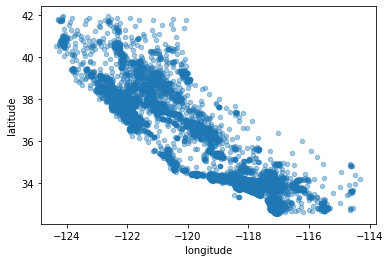

In [23]:
housing.plot(kind='scatter', x='longitude', y="latitude", alpha=0.4)

In [ ]:
housing.plot(kind='scatter', x='longitude', y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True
            )